>>>>> Enter 1 for 1D
>>>>> Enter 2 for housing
>>>>> Enter 3 for artsmall
>>>>> Enter 4 for crime
1

	============ Processing the data file: 1D ============

TRAINING SET:  (30, 1) (30, 1)
TESTING SET:  (60, 1) (60, 1)

Training data size: 30
Training feature size: 1

Testing data size: 60
Testing feature size: 1


	################ Kernel chosen for the process: Linear ################


	!!!!!!!! Execution Segment: GP Optimization !!!!!!!!

Total number of training iterations: 100
Linear Kernel => Finalized Alpha parameter: 2.4 
Linear Kernel => Finalized Beta parameter: 1.9

	!!!!!!!! Execution Segment: Mean and Variance Prediction with MSE and MNLL !!!!!!!!

Linear Kernel => Final MSE of test data set - 1D is:  0.411
Linear Kernel => Final MNLL of test data set - 1D is:  1.001

	!!!!!!!! Execution Segment: Evaluation and Performance as a Function of Training Iterations !!!!!!!!

Linear Kernel => MNLLs of test data set - 1D per Training set iteration is:  [1.1475556877062414, 1.0320

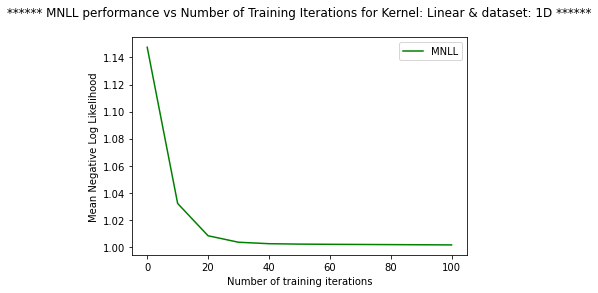


	!!!!!!!! Execution Segment: Visualizing Performance on the 1D Dataset !!!!!!!!



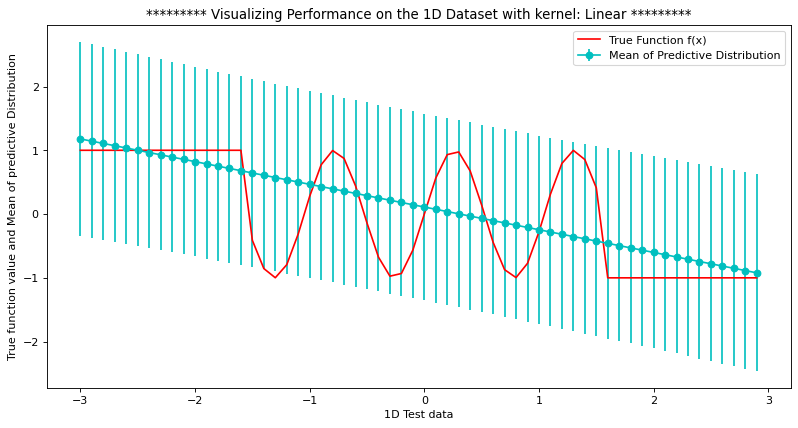


!!!!! Total Execution time for completing the Linear process: 0.3701918125152588 seconds!!!!!


	################ Kernel chosen for the process: RBF ################


	!!!!!!!! Execution Segment: GP Optimization !!!!!!!!

Total number of training iterations: 100
RBF Kernel => Finalized Alpha parameter: 1.3 
RBF Kernel => Finalized Beta parameter: 16.7
RBF Kernel => Finalized s parameter: 0.2

	!!!!!!!! Execution Segment: Mean and Variance Prediction with MSE and MNLL !!!!!!!!

RBF Kernel => Final MSE of test data set - 1D is:  0.071
RBF Kernel => Final MNLL of test data set - 1D is:  0.165

	!!!!!!!! Execution Segment: Evaluation and Performance as a Function of Training Iterations !!!!!!!!

RBF Kernel => MNLLs of test data set - 1D per Training set iteration is:  [1.2334409169276073, 0.9466475098356016, 0.6669970659360338, 0.4858504668813781, 0.3648572191161027, 0.2848305243027533, 0.23440149087081766, 0.2033654557532876, 0.18430095988336787, 0.17261185934270146, 0.16549797437143665

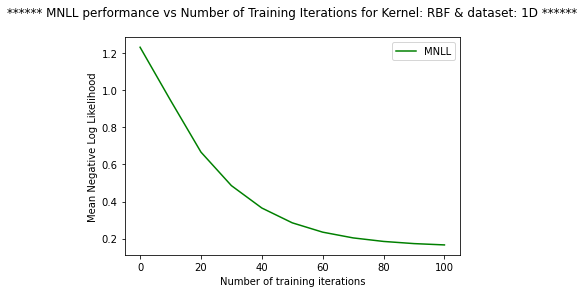


	!!!!!!!! Execution Segment: Visualizing Performance on the 1D Dataset !!!!!!!!



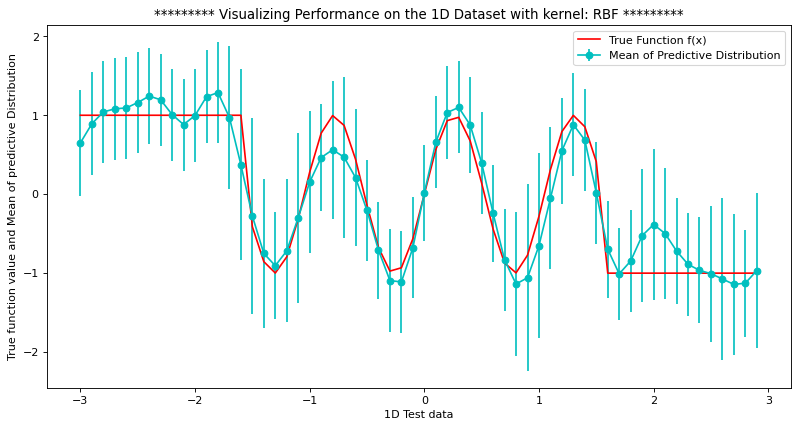


!!!!! Total Execution time for completing the RBF process: 1.6701979637145996 seconds!!!!!


=========== Total Execution time for completing the entire process: 3.692420721054077 seconds ===========


In [145]:
import re
import os
import sys
import math
import random
import csv
import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

# function to read the csv dataset
def read_files(file_name):
    data = []
    with open('pp4data/' + file_name, 'r') as f:
        # creating a csv reader object
        f_csv = csv.reader(f)
        # extracting each data row one by one
        for row in f_csv:
            data.append(row)
    return data

# function to compute the RBF kernel matrix 
def get_RBF_Kernel(phi1,phi2,s):
    # creating a 0 matrix of shape of dataset
    K = np.zeros([len(phi1),len(phi2)])
    for i in range(len(phi1)):
        for j in range(len(phi2)):
            K[i,j] = np.exp(-0.5*(np.linalg.norm(phi1[i]-phi2[j])**2)/(s**2))
    return(K)

# function for optimizing GP and computing optimized hyper-parameters
def GP_Optimization(phi_train,phi_test,t_train,t_test,kernel,inp):
    # initializing alpha,beta,s,learning rate(eta)
    alpha = 1
    beta = 1
    if inp == '1D': s = 0.1
    else: s = 5
    eta = 0.01
    iterations = 0
    N = len(phi_train) #no of rows or examples in training set
    # identity matrix of train set size
    I = np.identity(N)

    # compute initial kernel matrix according to the iteration for Linear and RBF kernel
    if(kernel == 'Linear'):
        K = (np.dot(phi_train,phi_train.T)+1)
    elif(kernel == 'RBF'):
        K = get_RBF_Kernel(phi_train,phi_train,s)

    # initialize empty lists for alpha,beta,s to store all the parameter values at each training iteration
    alpha_new = []
    beta_new = []
    s_new = []

    # compute intial covariance matrix and log evidence
    C_N = (I/beta) + (K/alpha)
    log_Ev_before = -(0.5*N*np.log(2*np.pi)) - 0.5*(np.log(np.linalg.det(C_N))) \
                                    - 0.5*(np.dot(np.dot(t_train.T,np.linalg.inv(C_N)),t_train))
    
    # initialize empty lists to store the MNLLs at each training iteration
    MNLL_list = []
    train_iter = []
    
    for i in range(1,101):
        
        # compute the MNLL at every 10th iteration including iteration 0 and store 
        # to check the performance as a fucntion of training iterations
        if (iterations%10==0):
            c, V = get_Prediction(phi_train,phi_test,t_test,alpha,beta,s,kernel)
            mean, var, MSE, MNLL = get_Mean_Variance_MSE_MNLL(c,V,C_N,t_train,t_test,inp)
            MNLL_list.append(MNLL)
            train_iter.append(iterations)
        
        # update alpha at every iteration untill log evidence convergence
        a = np.log(alpha)
        del_C_N_by_del_alpha = -(K/(alpha**2))
        del_log_Ev_by_del_alpha = -0.5*(np.trace(np.dot(np.linalg.inv(C_N),del_C_N_by_del_alpha))) \
                                    + 0.5*(np.dot(np.dot(np.dot(np.dot(t_train.T,np.linalg.inv(C_N)),\
                                        del_C_N_by_del_alpha),np.linalg.inv(C_N)),t_train))
        
        a = a + eta*del_log_Ev_by_del_alpha*alpha
        alpha = np.exp(a).item()

        # update beta at every iteration untill log evidence convergence
        b = np.log(beta)
        del_C_N_by_del_beta = -(I/(beta**2))
        del_log_Ev_by_del_beta = -0.5*(np.trace(np.dot(np.linalg.inv(C_N),del_C_N_by_del_beta))) \
                                    + 0.5*(np.dot(np.dot(np.dot(np.dot(t_train.T,np.linalg.inv(C_N)),\
                                        del_C_N_by_del_beta),np.linalg.inv(C_N)),t_train))
        
        b = b + eta*del_log_Ev_by_del_beta*beta
        beta = np.exp(b).item()

        # update the s parameter for GP with RBF kernel process
        if (kernel == 'RBF'):
            del_C_N_by_del_s = np.zeros([N,N])
            for i in range(N):
                for j in range(N):
                    xi_xj_norm = np.linalg.norm(phi_train[i]-phi_train[j])**2
                    k_intermediate = np.exp(-0.5*xi_xj_norm/(s**2))
                    del_C_N_by_del_s[i,j] = (k_intermediate*xi_xj_norm)/(s**3)

            del_log_Ev_by_del_s = -0.5*(np.trace(np.dot(np.linalg.inv(C_N),del_C_N_by_del_s))) \
                                    + 0.5*(np.dot(np.dot(np.dot(np.dot(t_train.T,np.linalg.inv(C_N)),\
                                        del_C_N_by_del_s),np.linalg.inv(C_N)),t_train))
            
            ln_s = np.log(s)
            ln_s = ln_s + eta * del_log_Ev_by_del_s * s
            s = np.exp(ln_s).item()
            s_new.append(s)

            # update the RBF kernel with updated s for new log evidence calculation
            K = get_RBF_Kernel(phi_train,phi_train,s)

        # compute the updated covariance matrix with new alpha,beta and K
        C_N_updated = (I/beta) + (K/alpha)
        # compute new log evidence 
        log_Ev_after = -(0.5*N*np.log(2*np.pi)) - 0.5*(np.log(np.linalg.det(C_N_updated))) \
                            - 0.5*(np.dot(np.dot(t_train.T,np.linalg.inv(C_N_updated)),t_train))
        
        # store the alpha, beta computed at the current iteration
        alpha_new.append(alpha)
        beta_new.append(beta)

        # check for the log evidence convergence for evidence optimization
        convergence = (log_Ev_after-log_Ev_before)/abs(log_Ev_before) 
        iterations = iterations+1
        if convergence <= math.pow(10,-5):
            break
        
        # update the log evidence and covariance variable with the current values to use in next iteration
        log_Ev_before = log_Ev_after
        C_N = C_N_updated

    #print("\n\t**************** The Kernel chosen : %s ****************\n"%kernel)
    print("Total number of training iterations:",iterations)
    print("%s Kernel => Finalized Alpha parameter: %s "%(kernel,round(alpha,1)))
    print("%s Kernel => Finalized Beta parameter: %s"%(kernel,round(beta,1)))
    if (kernel == 'RBF'):
        print("%s Kernel => Finalized s parameter: %s"%(kernel,round(s,1)))
    
    return (alpha, beta, s, alpha_new, beta_new, s_new, iterations, C_N_updated, K, MNLL_list, train_iter)

# function to compute covariance of test example, covariance matrix(V) of train set and test example
def get_Prediction(phi_train,phi_test,t_test,alpha,beta,s,kernel):
    
    N_test = len(phi_test)
    # test set c calculation
    if(kernel == 'Linear'):
        K_test = (np.dot(phi_test,phi_test.T)+1)
    elif(kernel == 'RBF'):
        K_test = get_RBF_Kernel(phi_test,phi_test,s)

    # identity matrix of test set size
    I_test = np.identity(N_test)
    cov = (I_test/beta) + (K_test/alpha)
    c = np.diag(cov)
    
    # update the kernel matrix for test example
    K_Vt = np.zeros([len(phi_train),len(phi_test)])
    if(kernel == 'Linear'):
        K_Vt = (np.dot(phi_train,phi_test.T)+1)
    elif(kernel == 'RBF'):
        K_Vt = get_RBF_Kernel(phi_train, phi_test, s)
        
    # train-test set V calculation
    V = (1/alpha) * K_Vt
    
    return(c,V)

# function to predict the mean, variance and compute the MSE, MNLL of test example
def get_Mean_Variance_MSE_MNLL(c,V,C_N_updated,t_train,t_test,inp):

    Mean = np.dot(np.dot(np.transpose(V),np.linalg.inv(C_N_updated)),t_train)
    #print("Shape of Mean matrix : ",Mean.shape)
    Var = np.diag(c - np.dot(np.dot(np.transpose(V),np.linalg.inv(C_N_updated)),V))
    #print("Shape of Variance matrix : ",Var.shape)
    MSE = np.mean(np.square(Mean - t_test))
    #print("MSE of test data set - %s is : "%inp,round(MSE,3))
    NLL = []
    for i in range(len(t_test)):
        l = 1/(np.sqrt(2*np.pi*Var[i])) * np.exp(-0.5*((t_test[i]-Mean[i])**2)/Var[i])
        nl = -np.log(l)
        NLL.append(nl.item())

    MNLL = np.mean(NLL)
    #print("MNLL of test data set - %s is : "%inp,round(MNLL,3))
    
    return(Mean, Var, MSE, MNLL)

# function to plot the MNLL as a function of the number of training iterations
def plot_MNLL_vs_TrainIter(MNLL_List,Train_Iter,k):
    x = Train_Iter
    plt.plot(x,MNLL_List,color='g',label = "MNLL")
    plt.xlabel('Number of training iterations')
    plt.ylabel('Mean Negative Log Likelihood')
    plt.title('****** MNLL performance vs Number of Training Iterations for Kernel: %s & dataset: %s ******\n'%(k,inp))
    plt.legend()
    plt.show()

# function to visualize the performance on 1D dataset
def plot_Performance_1D(Mean,Var,k):

    # initialize empty list to store the true function values
    f_x = []
    # x ranges from -3 to 3 as in 1D dataset examples
    xval = list(map(lambda x : round(x,1),np.arange(-3,3,0.1)))
    # update the true function
    for x in xval:
        if x > 1.5 : f_x.append(-1)
        elif x < -1.5 : f_x.append(1)
        else : f_x.append(math.sin(6*x))
    #print("\n%s Kernel => True function values for 1D dataset : "%k,f_x)
    #print("\n%s Kernel => Mean of the Predictive Distribution for 1D datsaet : "%k,Mean)
    
    # computing error of +/-2 times of standard deviations
    sd = np.sqrt(Var)
    error_around_mean = 2*sd
    
    figure(figsize=(12, 6), dpi=80) #dimensions of the figure
    plt.plot(xval,f_x,color='r',label = "True Function f(x)")
    plt.errorbar(xval, Mean, yerr=error_around_mean,color='c',fmt='-o',label = "Mean of Predictive Distribution")
    plt.xlabel('1D Test data')
    plt.ylabel('True function value and Mean of predictive Distribution')
    plt.title('********* Visualizing Performance on the 1D Dataset with kernel: %s *********'%k)
    plt.legend()
    plt.show()

# main function 
if __name__ == "__main__": 
    
    start_main = time.time()
    # input file reading process
    files = os.listdir('pp4data')
    datasets=[]
    for i in files:
        datasets.append(i.split('-')[1].split('.')[0])
    unique_files = list(set(datasets))

    for i in range(len(unique_files)):
        print(">>>>> Enter %d for %s"%((i+1),unique_files[i]))
    inp = unique_files[int(input())-1]
    print("\n\t============ Processing the data file: %s ============\n"%inp)

    train_set = read_files('train-'+inp+'.csv')
    train_label = read_files('trainR-'+inp+'.csv')
    print("TRAINING SET: ",(len(train_set),len(train_set[0])),(len(train_label),len(train_label[0])))
    test_set = read_files('test-'+inp+'.csv')
    test_label = read_files('testR-'+inp+'.csv')
    print("TESTING SET: ",(len(test_set),len(test_set[0])),(len(test_label),len(test_label[0])))

    train_size = len(train_set)
    train_features = len(train_set[0])
    print("\nTraining data size: %s\nTraining feature size: %s\n"%(train_size,train_features))
    test_size = len(test_set)
    test_features = len(test_set[0])
    print("Testing data size: %s\nTesting feature size: %s\n"%(test_size,test_features))

    phi_train = np.array(train_set,dtype=float)
    t_train = np.array(train_label,dtype=float)
    phi_test = np.array(test_set,dtype=float)
    t_test = np.array(test_label,dtype=float)
    
    for k in ['Linear','RBF']:
        
        # initializing start time for current kernel process loop
        k_start = time.time()
        print("\n\t################ Kernel chosen for the process: %s ################\n"%k)
        print("\n\t!!!!!!!! Execution Segment: GP Optimization !!!!!!!!\n")
        Alpha,Beta,S,Alpha_new,Beta_new,S_new,Iter,C_N_updated,\
                    K_updated, MNLL_List, Train_Iter = GP_Optimization(phi_train,phi_test,t_train,t_test,k,inp)
        
        #print("\n\t!!!!!!!! Execution Segment : Calculate test set c and V !!!!!!!!\n")
        c, V = get_Prediction(phi_train,phi_test,t_test,Alpha,Beta,S,k)
        #print("shape of Final test c matrix is: ", c.shape)
        #print("shape of Final test V matrix is: ", V.shape)
        
        print("\n\t!!!!!!!! Execution Segment: Mean and Variance Prediction with MSE and MNLL !!!!!!!!\n")
        mean, var, MSE, MNLL = get_Mean_Variance_MSE_MNLL(c,V,C_N_updated,t_train,t_test,inp)
        MNLL_List.append(MNLL)
        Train_Iter.append(Iter)
        
        #print("%s Kernel => Shape of Final Mean matrix : "%k,mean.shape)
        #print("%s Kernel => Shape of Final Variance matrix : "%k,var.shape)
        print("%s Kernel => Final MSE of test data set - %s is: "%(k,inp),round(MSE,3))
        print("%s Kernel => Final MNLL of test data set - %s is: "%(k,inp),round(MNLL,3))

        print("\n\t!!!!!!!! Execution Segment: Evaluation and Performance as a Function of Training Iterations !!!!!!!!\n")
        print("%s Kernel => MNLLs of test data set - %s per Training set iteration is: "%(k,inp),MNLL_List)
        print("\n%s Kernel => Training set iterations: "%k,Train_Iter)
        
        # function call for the MNLL vs Training Iteration plot
        plot_MNLL_vs_TrainIter(MNLL_List,Train_Iter,k)
        # function call to get plot for 1D dataset performance 
        if inp == '1D':
            print("\n\t!!!!!!!! Execution Segment: Visualizing Performance on the 1D Dataset !!!!!!!!\n")
            plot_Performance_1D(mean,var,k)
        # end time for the current kernel process loop
        k_end = time.time()
        print('\n!!!!! Total Execution time for completing the %s process: %s seconds!!!!!\n'%(k,k_end - k_start))
              
end_main = time.time()
print('\n=========== Total Execution time for completing the entire process: %s seconds ==========='%(end_main - start_main))
